# Deep Learning for Computer Vision:  Name / No name classifier

## Aryeh Zapinsky and Jonathan Herman

In [116]:
import os
import shutil
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras import backend
from keras import optimizers

%matplotlib inline

### Prepare data

##### Get data into this form:

In [2]:
# DL4Baseball
# |-- name_data`
# |   |-- train
# |       |-- name
# |       |-- not_name
# |---|-- validation
#         |-- name
#         |-- not_name
# ...

In [4]:
# Separate data into at-bats, not at-bats, training and validation
%mkdir -p ./name_data/train/name
%mkdir -p ./name_data/train/no_name
%mkdir -p ./name_data/validation/name
%mkdir -p ./name_data/validation/no_name

In [ ]:
#### Count files 
#find ./name/ -type f | wc -l         # 580
#find ./no_name/ -type f | wc -l     # 13,817

### Fill training and validation dirs

##### Using 87/13 train/test split:

./name_data/train/name -- 500 samples

./name_data/train/no_name -- 11912 samples

./name_data/validation/name -- 80 samples

./name_data/validation/no_name -- 1905 samples

We will augment the data to have even more samples.

In [9]:
def prepare_dir(label, dest, size):
    '''Move SIZE samples of LABEL imgs into DEST'''
    source = './name_data/' + label + '/'
    dest = './name_data/' + dest + '/' + label + '/' 
    # random selection of SIZE of LABEL
    train_sample = np.random.choice(os.listdir(source), size=size, replace=False)
    
    for fp in train_sample:
        shutil.move(source + fp, dest + fp)        

# Prepare training sets according to sizes above
print('Preparing name training set...')
prepare_dir('name', dest='train', size=500)
print('Preparing no_names training set...')
prepare_dir('no_name', dest='train', size=11912)

# Prepare validation sets according to sizes above
print('Preparing name validation set...')
prepare_dir('name', dest='validation', size=80)
print('Preparing no_name validation set...')
prepare_dir('no_name', dest='validation', size=1905)

Preparing name training set...
Preparing no_names training set...
Preparing name validation set...
Preparing no_name validation set...


### Augment Data

In [22]:
# Image info
train_data_dir = './name_data/train/'
validation_data_dir = './name_data/validation/'
img_width, img_height = (300, 300)

# Calculate steps per epoch
nb_train_samples = 12411
nb_validation_samples = 1984
batch_size = 32
steps_per_epoch_train = nb_train_samples / batch_size
steps_per_epoch_val = nb_validation_samples / batch_size

In [86]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.3,
        height_shift_range=0.2,
        fill_mode='nearest')

# Data augmentation for testing (only scaling)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 12411 images belonging to 2 classes.
Found 1984 images belonging to 2 classes.


Let's display some sample images from this dataset. This is like finding a needle in a haystack with 1/20 shot of finding a name image.

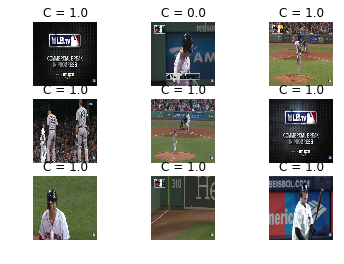

In [62]:
for X_batch, Y_batch in validation_generator:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
        plt.title("C = {}".format(Y_batch[i]))
        plt.axis('off')
    plt.show()
    break

## 1. Build VGG-16

In [76]:
def build_vgg16(framework='tf'):

    if framework == 'th':
        # build the VGG16 network in Theano weight ordering mode
        backend.set_image_dim_ordering('th')
    else:
        # build the VGG16 network in Tensorflow weight ordering mode
        backend.set_image_dim_ordering('tf')
        
    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    else:
        model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))
        
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

## 2. Load pretrained weights

Now we build the model using tensorflow format and load the weights.

In [77]:
# path to the model weights files.
weights_path = './vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
tf_model = build_vgg16('tf')
tf_model.load_weights(weights_path)

Next we make the last layer or layers. We flatten the output from the last convolutional layer, and add fully connected layer with 256 hidden units. Finally, we add the output layer which is a scalar output as we have a binary classifier. 

## 3. Add a fully connected layer

In [78]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
print (Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
print (tf_model.summary())
print(top_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14 (ZeroPaddi (None, 302, 302, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 302, 302, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 152, 152, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
__________

We add this model to the top of our VGG16 network, freeze all the weights except the top, and compile.

In [79]:
# add the model on top of the convolutional base
tf_model.add(top_model)

## 4. Freeze all but last two layers

In [80]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in tf_model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

## 5. Fine tune network on Dogs and Cats

Now we train for 5 epochs to get the weights for the top close to where we need them. Essentially, we want the network to be doing the right thing before we unnfreeze the lower weights.

In [81]:
# Bookkeeping
% mkdir -p ./logs/vgg16_top_tuning
% mkdir -p ./history
% mkdir -p ./models

In [82]:
nb_epochs = 5

tensorboard_callback = TensorBoard(log_dir='./logs/vgg16_top_tuning/', 
                                   histogram_freq=0, 
                                   write_graph=True, 
                                   write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vgg16_top_tuning_best.hdf5', 
                                      monitor='val_acc', 
                                      verbose=0, 
                                      save_best_only=True, 
                                      save_weights_only=False, 
                                      mode='auto', period=1)

vgg16_top_convet = tf_model.fit_generator(train_generator, 
              initial_epoch=0, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epochs, 
              callbacks=[tensorboard_callback, checkpoint_callback],
              validation_steps=steps_per_epoch_val)

pandas.DataFrame(vgg16_top_convet.history).to_csv("./history/\
vgg16_top_tuning_weights.csv")

Epoch 1/5
388/387 [==============================] - 340s 875ms/step - loss: 0.1554 - acc: 0.9586 - val_loss: 0.1181 - val_acc: 0.9627
Epoch 2/5
388/387 [==============================] - 330s 849ms/step - loss: 0.1057 - acc: 0.9636 - val_loss: 0.0647 - val_acc: 0.9677
Epoch 3/5
388/387 [==============================] - 328s 846ms/step - loss: 0.0862 - acc: 0.9674 - val_loss: 0.0533 - val_acc: 0.9819
Epoch 4/5
388/387 [==============================] - 330s 851ms/step - loss: 0.0717 - acc: 0.9743 - val_loss: 0.0495 - val_acc: 0.9814
Epoch 5/5
388/387 [==============================] - 331s 854ms/step - loss: 0.0620 - acc: 0.9778 - val_loss: 0.0453 - val_acc: 0.9798


In [85]:
tf_model = load_model('./models/vgg16_top_tuning_best.hdf5')

nb_epochs = 7

tensorboard_callback = TensorBoard(log_dir='./logs/vgg16_top_tuning/', 
                                   histogram_freq=0, 
                                   write_graph=True, 
                                   write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vgg16_top_tuning_best.hdf5', 
                                      monitor='val_acc', 
                                      verbose=0, 
                                      save_best_only=True, 
                                      save_weights_only=False, 
                                      mode='auto', period=1)

vgg16_top_convet = tf_model.fit_generator(train_generator, 
              initial_epoch=0, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epochs, 
              callbacks=[tensorboard_callback, checkpoint_callback],
              validation_steps=steps_per_epoch_val)

pandas.DataFrame(vgg16_top_convet.history).to_csv("./history/\
vgg16_top_tuning_weights.csv")

Epoch 1/7
388/387 [==============================] - 341s 879ms/step - loss: 0.0702 - acc: 0.9732 - val_loss: 0.0548 - val_acc: 0.9798
Epoch 2/7
388/387 [==============================] - 330s 850ms/step - loss: 0.0588 - acc: 0.9771 - val_loss: 0.0378 - val_acc: 0.9864
Epoch 3/7
388/387 [==============================] - 329s 847ms/step - loss: 0.0536 - acc: 0.9803 - val_loss: 0.0346 - val_acc: 0.9889
Epoch 4/7
388/387 [==============================] - 328s 846ms/step - loss: 0.0534 - acc: 0.9811 - val_loss: 0.0371 - val_acc: 0.9854
Epoch 5/7
388/387 [==============================] - 330s 850ms/step - loss: 0.0488 - acc: 0.9832 - val_loss: 0.0282 - val_acc: 0.9924
Epoch 6/7
388/387 [==============================] - 328s 845ms/step - loss: 0.0417 - acc: 0.9851 - val_loss: 0.0229 - val_acc: 0.9955


# THIS IS NOT WORKING AS IT SHOULD

In [87]:
tf_model = load_model('./models/vgg16_top_tuning_best.hdf5')

nb_epoch = 10
vgg16_top_convet = tf_model.fit_generator(train_generator, 
              initial_epoch=7, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epochs, 
              callbacks=[tensorboard_callback, checkpoint_callback],
              validation_steps=steps_per_epoch_val)

pandas.DataFrame(vgg16_top_convet.history).to_csv("./history/\
vgg16_top_tuning_weights.csv")

## 6. Evaluate Accuracy

Running this, we see that it gets 92% accuracy on the validation set, so we've halved the errors from before.

In [98]:
accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
       break
       
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies),
                                                   np.mean(losses)))

Validation: accuracy = 0.996875  ;  loss = 0.021093


In [94]:
nb_classes = 2
class_name = {
    0: 'name',
    1: 'no_name',
}

def show_sample(X, y, prediction=-1):
    im = X
    plt.imshow(im)
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
    else:
        plt.title("Class = %s" % (class_name[y]))

    plt.axis('off')
    plt.show()

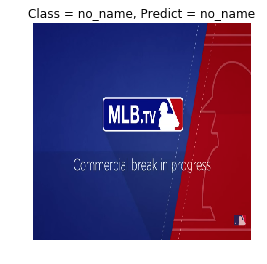

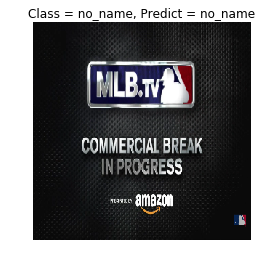

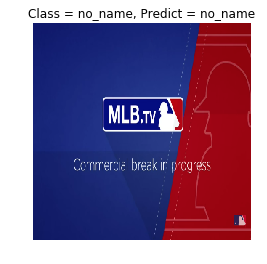

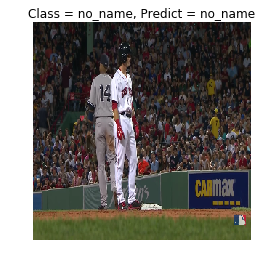

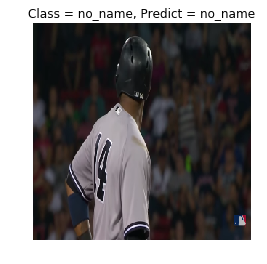

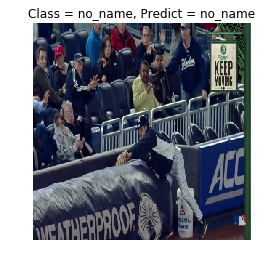

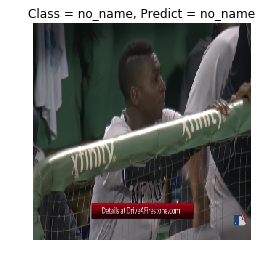

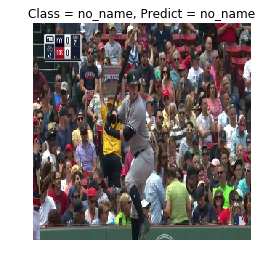

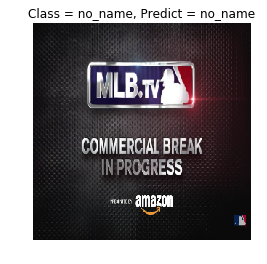

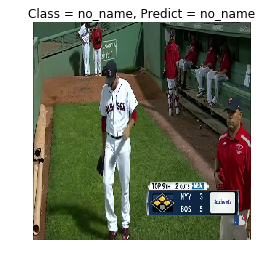

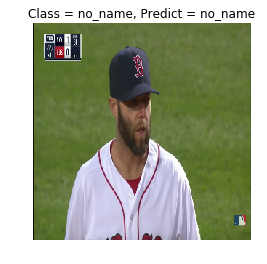

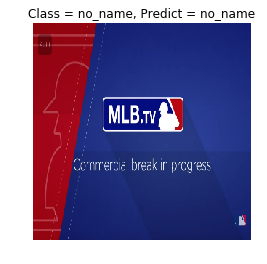

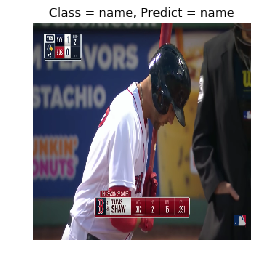

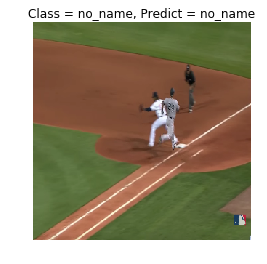

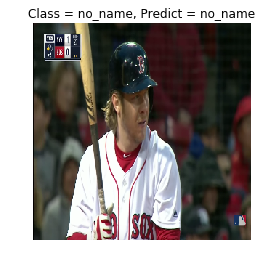

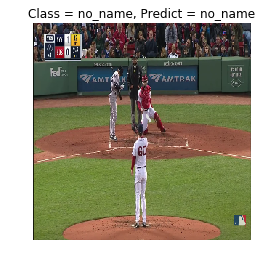

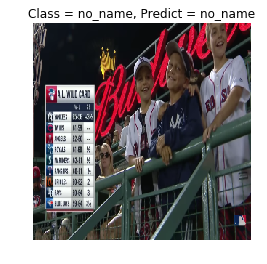

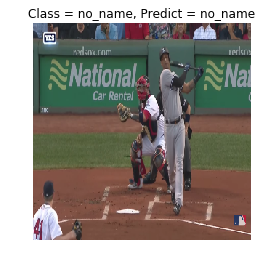

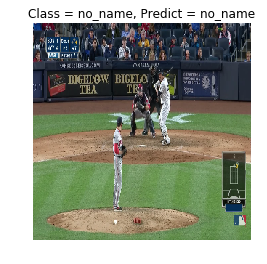

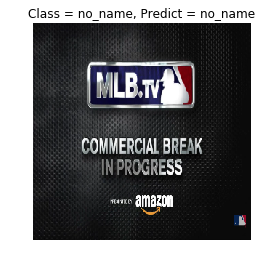

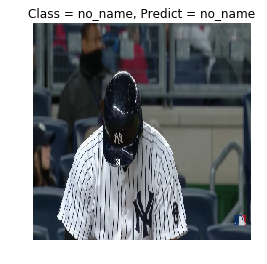

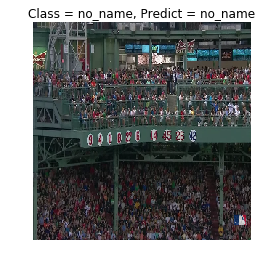

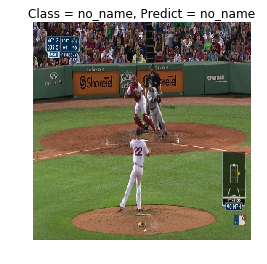

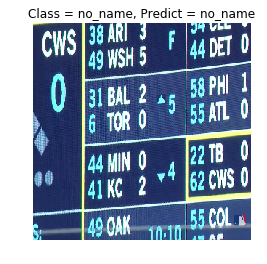

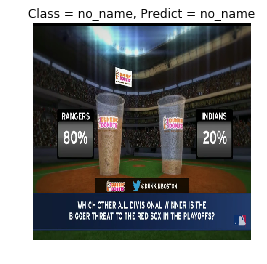

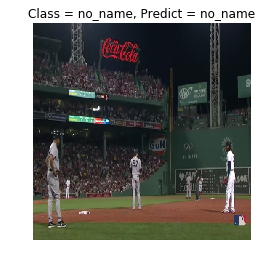

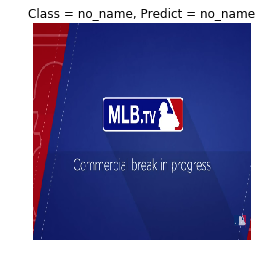

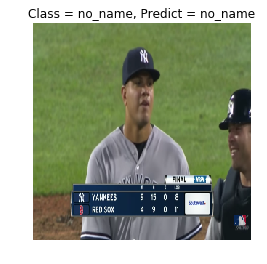

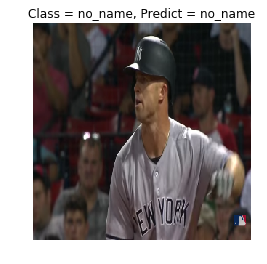

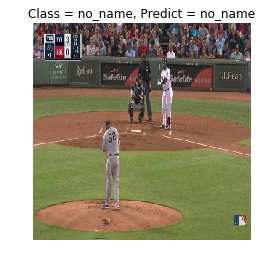

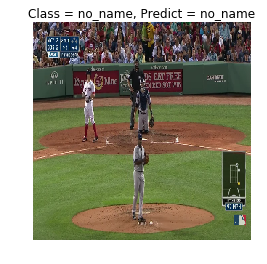

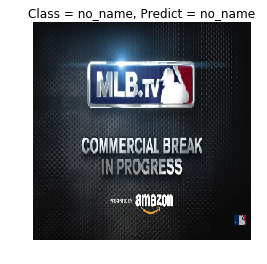

In [99]:
X_test, y_test = next(validation_generator)
predictions = tf_model.predict_classes(X_test, batch_size=32, verbose=0)

for i in range(32):
    show_sample(X_test[i, :, :, :], y_test[i], prediction=predictions[i, 0])

## 7. Unfreeze all layers

Now we can unnfreeze the lower layers.

In [100]:
# set all layers to trainable (updating weights)
for layer in tf_model.layers[:25]:
    layer.trainable = True

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

## 8. Fine tune entire network

We will let this train for 10 epochs.

In [101]:
tf_model = load_model('./models/vgg16_top_tuning_best.hdf5')

nb_epochs = 10

tensorboard_callback = TensorBoard(log_dir='./logs/vgg16_whole_after_top/', 
                                   histogram_freq=0, 
                                   write_graph=True, 
                                   write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vgg16_best.hdf5', 
                                      monitor='val_acc', 
                                      verbose=0, 
                                      save_best_only=True, 
                                      save_weights_only=False, 
                                      mode='auto', period=1)

vgg16_whole_convet = tf_model.fit_generator(train_generator, 
              initial_epoch=0, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epochs, 
              callbacks=[tensorboard_callback, checkpoint_callback],
              validation_steps=steps_per_epoch_val)

pandas.DataFrame(vgg16_whole_convet.history).to_csv("./history/\
vgg16_whole_after_top_weights.csv")

Epoch 1/10
388/387 [==============================] - 340s 876ms/step - loss: 0.0368 - acc: 0.9867 - val_loss: 0.0214 - val_acc: 0.9945
Epoch 2/10
388/387 [==============================] - 329s 847ms/step - loss: 0.0376 - acc: 0.9866 - val_loss: 0.0240 - val_acc: 0.9940
Epoch 3/10
388/387 [==============================] - 328s 845ms/step - loss: 0.0326 - acc: 0.9891 - val_loss: 0.0193 - val_acc: 0.9955
Epoch 4/10
388/387 [==============================] - 328s 846ms/step - loss: 0.0313 - acc: 0.9895 - val_loss: 0.0198 - val_acc: 0.9955
Epoch 5/10
388/387 [==============================] - 328s 845ms/step - loss: 0.0322 - acc: 0.9890 - val_loss: 0.0208 - val_acc: 0.9940
Epoch 6/10
388/387 [==============================] - 328s 846ms/step - loss: 0.0311 - acc: 0.9899 - val_loss: 0.0182 - val_acc: 0.9960
Epoch 7/10
388/387 [==============================] - 328s 846ms/step - loss: 0.0275 - acc: 0.9903 - val_loss: 0.0174 - val_acc: 0.9965
Epoch 8/10
388/387 [============================

In [117]:
tf_model = load_model('./models/vgg16_top_tuning_best.hdf5')

# Data augmentation for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.3,
        height_shift_range=0.2,
        fill_mode='nearest')

# Data augmentation for testing (only scaling)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

nb_epochs = 10

tensorboard_callback = TensorBoard(log_dir='./logs/vgg16_whole_early_stop/', 
                                   histogram_freq=0, 
                                   write_graph=True, 
                                   write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vgg16_early_best.hdf5', 
                                      monitor='val_acc', 
                                      verbose=0, 
                                      save_best_only=True, 
                                      save_weights_only=False, 
                                        mode='auto', period=1)

earlystop_callback = EarlyStopping(monitor='val_loss', 
                                   min_delta=0.01, 
                                   patience=10,
                                   verbose=0, 
                                   mode='auto')



vgg16_whole_convet = tf_model.fit_generator(train_generator, 
              initial_epoch=0, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epochs, 
              callbacks=[tensorboard_callback, 
                         checkpoint_callback,
                        earlystop_callback],
              validation_steps=steps_per_epoch_val)

pandas.DataFrame(vgg16_whole_convet.history).to_csv("./history/\
vgg16_whole_early_stop_weights.csv")

Found 12411 images belonging to 2 classes.
Found 1984 images belonging to 2 classes.
Epoch 1/10
388/387 [==============================] - 340s 876ms/step - loss: 0.0374 - acc: 0.9878 - val_loss: 0.0229 - val_acc: 0.9934
Epoch 2/10
388/387 [==============================] - 333s 857ms/step - loss: 0.0366 - acc: 0.9867 - val_loss: 0.0239 - val_acc: 0.9924
Epoch 3/10
388/387 [==============================] - 332s 856ms/step - loss: 0.0353 - acc: 0.9876 - val_loss: 0.0193 - val_acc: 0.9965
Epoch 4/10
388/387 [==============================] - 328s 846ms/step - loss: 0.0297 - acc: 0.9900 - val_loss: 0.0260 - val_acc: 0.9919
Epoch 5/10
388/387 [==============================] - 329s 848ms/step - loss: 0.0311 - acc: 0.9890 - val_loss: 0.0219 - val_acc: 0.9945
Epoch 6/10
388/387 [==============================] - 328s 845ms/step - loss: 0.0299 - acc: 0.9900 - val_loss: 0.0245 - val_acc: 0.9924
Epoch 7/10
388/387 [==============================] - 328s 846ms/step - loss: 0.0290 - acc: 0.9897 

# 9. Evaluate accuracy

We get to 97% accuracy!

In [119]:
accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
       break
       
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies),
                                                   np.mean(losses)))

Validation: accuracy = 0.998437  ;  loss = 0.017888


In [ ]:
X_test, y_test = next(validation_generator)
predictions = tf_model.predict_classes(X_test, batch_size=32, verbose=0)

for i in range(32):
    show_sample(X_test[i, :, :, :], y_test[i], prediction=predictions[i, 0])